# 【考察】パブリックLB期間でLow側のスコアが劣化する要因
コンペティションのスコアは、以下のようにHigh側のランク相関とLow側のランク相関の両者によって決まります。ここでパブリックリーダーボード期間（2020/1/1～2020/11/30）において、Low側のランク相関が低くなってしまいトータルのスコアが向上しないという経験をされた参加者の声を聞きました。

score = (rho_high - 1)^2 + (rho_low - 1)^2

今回は、その要因について解説します。

In [1]:
import pickle
import datetime
import warnings

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from IPython.display import Image

from sklearn.linear_model import LinearRegression
from tqdm.auto import tqdm

%matplotlib inline
pd.options.display.max_rows = 100
pd.options.display.max_columns = 100
pd.options.display.width = 120
warnings.simplefilter('ignore')

In [2]:
def pickle_dump(obj, path):
    with open(path, mode='wb') as f:
        pickle.dump(obj,f)

def pickle_load(path):
    with open(path, mode='rb') as f:
        data = pickle.load(f)
        return data

In [3]:
# チュートリアルのtrain_X, val_X, test_X, train_y, val_y, test_y　私はpickleで保存しています
# ""の中身はご自身の環境に合わせて定義してください
train_X = pickle_load("...")
val_X = pickle_load("...")
test_X = pickle_load("...")
train_y = pickle_load("...")
val_y = pickle_load("...")
test_y = pickle_load("...")

In [4]:
# データセットの読み込み
# ""の中身はご自身の環境に合わせて定義してください
dataset_dir="..."
inputs = {
    "stock_list": f"{dataset_dir}/stock_list.csv",
    "stock_price": f"{dataset_dir}/stock_price.csv",
    "stock_fin": f"{dataset_dir}/stock_fin.csv",
    "stock_labels": f"{dataset_dir}/stock_labels.csv",
}

dfs = {}
for k, v in inputs.items():
    dfs[k] = pd.read_csv(v)

# データ整理
まず初めに、全期間のデータを一つのデータフレームにまとめます。

In [5]:
tmp_train = pd.concat([train_X["label_high_20"], train_y["label_high_20"], train_y["label_low_20"]], axis=1)
tmp_val = pd.concat([val_X["label_high_20"], val_y["label_high_20"], val_y["label_low_20"]], axis=1)
tmp_test = pd.concat([test_X["label_high_20"], test_y["label_high_20"], test_y["label_low_20"]], axis=1)

tmp_df = pd.concat([tmp_train, tmp_val, tmp_test])
tmp_df = tmp_df.reset_index()
tmp_df

,datetime,return_1month,return_2month,return_3month,volatility_1month,volatility_2month,volatility_3month,MA_gap_1month,MA_gap_2month,MA_gap_3month,Result_FinancialStatement FiscalYear,Result_FinancialStatement NetSales,Result_FinancialStatement OperatingIncome,Result_FinancialStatement OrdinaryIncome,Result_FinancialStatement NetIncome,Result_FinancialStatement TotalAssets,Result_FinancialStatement NetAssets,Result_FinancialStatement CashFlowsFromOperatingActivities,Result_FinancialStatement CashFlowsFromFinancingActivities,Result_FinancialStatement CashFlowsFromInvestingActivities,Forecast_FinancialStatement FiscalYear,Forecast_FinancialStatement NetSales,Forecast_FinancialStatement OperatingIncome,Forecast_FinancialStatement OrdinaryIncome,Forecast_FinancialStatement NetIncome,Result_Dividend FiscalYear,Result_Dividend QuarterlyDividendPerShare,Result_Dividend AnnualDividendPerShare,Forecast_Dividend FiscalYear,Forecast_Dividend QuarterlyDividendPerShare,Forecast_Dividend AnnualDividendPerShare,code,label_high_20,label_low_20
0,2016-02-05,-0.022140,0.000000,0.000000,0.016141,0.000000,0.000000,1.000189,0.000000,0.000000,2016.0,178890.0,2467.0,2688.0,1133.0,114363.0,23417.0,0.0,0.0,0.0,2016.0,229000.0,2600.0,3000.0,2200.0,0.0,0.0,0.0,2016.0,5.0,5.0,1301,0.03019,-0.05660
1,2016-05-09,0.015564,-0.036900,-0.015094,0.010985,0.012129,0.012798,1.002112,0.987701,0.990951,2016.0,226626.0,2433.0,2814.0,1799.0,94608.0,23065.0,2689.0,2482.0,-5114.0,2017.0,117000.0,1400.0,1300.0,800.0,2016.0,5.0,5.0,2017.0,50.0,50.0,1301,0.03448,-0.01149
2,2016-08-05,-0.011407,-0.029851,-0.011407,0.009727,0.011334,0.009773,0.989157,0.991704,0.986343,2017.0,52206.0,467.0,380.0,551.0,101632.0,22995.0,0.0,0.0,0.0,2017.0,117000.0,1400.0,1300.0,800.0,2016.0,5.0,5.0,2017.0,50.0,50.0,1301,0.02692,0.00000
3,2016-11-04,-0.024240,0.025475,0.037308,0.007637,0.008217,0.007867,0.980620,0.986900,0.999926,2017.0,109570.0,1171.0,1004.0,1186.0,106554.0,23600.0,0.0,0.0,0.0,2017.0,244000.0,3500.0,3300.0,2100.0,2016.0,5.0,5.0,2017.0,50.0,50.0,1301,0.00779,-0.03967
4,2017-02-10,0.008450,0.018175,0.044918,0.004767,0.005084,0.005005,1.007839,1.006462,1.013570,2017.0,179975.0,2872.0,2827.0,2449.0,117168.0,25779.0,0.0,0.0,0.0,2017.0,244000.0,3500.0,3300.0,2100.0,2016.0,5.0,5.0,2017.0,50.0,50.0,1301,0.15665,0.00401
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78847,2020-01-31,-0.139918,-0.111898,-0.116901,0.011450,0.012147,0.012522,0.924506,0.901607,0.886929,2020.0,137578.0,7274.0,7389.0,4594.0,227411.0,102850.0,0.0,0.0,0.0,2020.0,180000.0,11000.0,11000.0,7000.0,2020.0,8.0,0.0,2020.0,8.0,16.0,9997,0.05263,-0.15630
78848,2020-05-13,0.060166,0.057971,-0.210201,0.027223,0.041445,0.037304,1.046917,1.078002,1.006500,2020.0,179948.0,10311.0,10365.0,5862.0,223128.0,102525.0,6624.0,5712.0,-11108.0,2021.0,77900.0,-600.0,-100.0,-60.0,2020.0,8.0,16.0,2021.0,8.0,0.0,9997,0.27202,-0.09980
78849,2020-07-31,0.229885,0.244186,0.528571,0.027256,0.027960,0.030361,1.068779,1.131078,1.220068,2021.0,48534.0,2468.0,2669.0,1492.0,230242.0,103798.0,0.0,0.0,0.0,2021.0,77900.0,-600.0,-100.0,-60.0,2020.0,8.0,16.0,2021.0,8.0,0.0,9997,0.45394,0.09746
78850,2020-10-29,0.038866,-0.026575,0.127708,0.026797,0.027906,0.029594,1.027052,1.027426,1.020517,2021.0,48534.0,2468.0,2669.0,1492.0,230242.0,103798.0,0.0,0.0,0.0,2021.0,91139.0,4565.0,5124.0,2923.0,2020.0,8.0,16.0,2021.0,8.0,0.0,9997,0.01112,-0.17796


# 年別のランク相関、およびスコア推移（volatility_1month）
続いてこのデータを年次でくくり、説明力の高いvolatility_1monthのランク相関の推移を観察します。  
なおLow側はvolatility_1monthとラベルの相関は負となるのでマイナスを乗じておきます。

> ＜ボラティリティとラベルLowが負相関となる理由＞  
　株価の動きをランダムウォークと考えると、ボラティリティの大きい銘柄ほど一定期間経過した後の値幅の広がりが大きくなります。このため、ボラティリティの大きい銘柄の高値は高くなりやすく、安値は低くなりやすくなります。結果としてボラティリティとラベルHighは正相関、ラベルLowは負相関となります。

volatility_1monthは強力な指標であり、単体でもランク相関が0.25程度、スコアは1.1台を出すことができます。ただし、2016年と2020年（LB期間）はLow側のランク相関が悪く、そのためスコアも1.4程度で高止まりすることが分かります。

(0.8, 1.6)

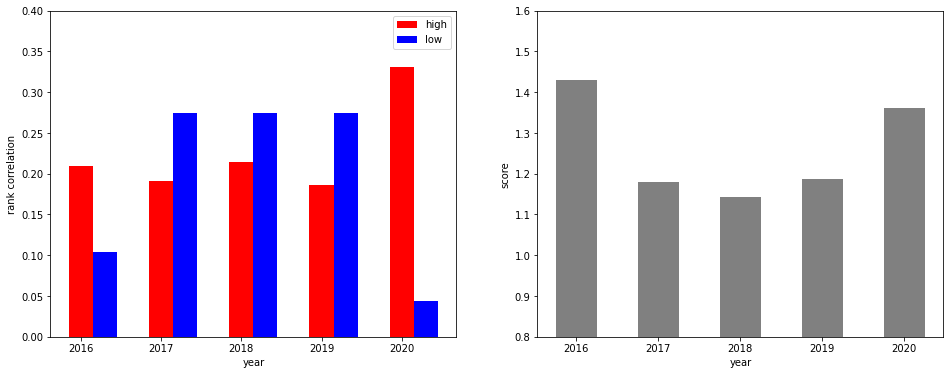

In [42]:
tmp = tmp_df.copy()
tmp["year"] = tmp["datetime"].dt.year

year = []
rank_corr_high = []
rank_corr_low = []
score = []

for y in sorted(tmp["year"].unique()):
    tmptmp = tmp[tmp["year"]==y].copy()
    tmp_high = tmptmp["label_high_20"].rank().corr(tmptmp["volatility_1month"].rank())
    tmp_low  = -tmptmp["label_low_20"].rank().corr(tmptmp["volatility_1month"].rank())
    
    year.append(y)
    rank_corr_high.append(tmp_high)
    rank_corr_low.append(tmp_low)
    score.append((tmp_high-1)**2+(tmp_low-1)**2)

fig,ax = plt.subplots(nrows=1, ncols=2, figsize=(16,6))

left = np.arange(len(year))
width = 0.3

ax[0].bar(left,       rank_corr_high, color="r", width=width, align="center")
ax[0].bar(left+width, rank_corr_low,  color="b", width=width, align="center")
ax[0].set_xticklabels(["", "2016", "2017", "2018", "2019", "2020"])
ax[0].legend(["high", "low"])
ax[0].set_xlabel("year")
ax[0].set_ylabel("rank correlation")
ax[0].set_ylim(0, 0.4)

ax[1].bar(year, score, width=0.5 , color="grey")
ax[1].set_xlabel("year")
ax[1].set_ylabel("score")
ax[1].set_ylim(0.8, 1.6)

# 月別のランク相関推移
では、もう少し詳しく見ていきましょう。次は2020年を月次に区切ってさらに細かく観察します。  
するとlabel_lowについて、2020年3月のランク相関が著しく低いことが分かります。  
2020年3月と言えば、記憶に新しいコロナショックです。ここが何らかの悪さをしてそうです。

ここで1つの疑問が生じます。確かに2020年3月はvolatility_1monthのランク相関が低くなっていますが、それ以外の期間ではほぼほぼ0.20台のランク相関をキープしています。それにも関わらず、LB期間（2020年）の通算におけるvolatility_1monthのランク相関は0.04程度と著しく低くなっています。これはなぜでしょうか？？

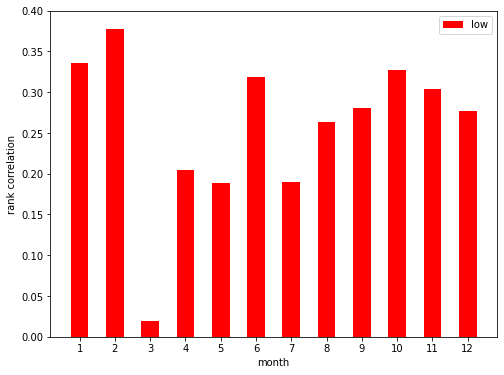

In [45]:
tmp = tmp_df.copy()
tmp["year"] = tmp["datetime"].dt.year
tmp["month"] = tmp["datetime"].dt.month
tmp["year_month"] = tmp["year"]*100 + tmp["month"]
tmp = tmp[tmp["year"]==2020]

month = []
rank_corr_high = []
rank_corr_low = []
score = []

for m in sorted(tmp["month"].unique()):
    tmptmp = tmp[tmp["month"]==m].copy()
    tmp_high = tmptmp["label_high_20"].rank().corr(tmptmp["volatility_1month"].rank())
    tmp_low  = -tmptmp["label_low_20"].rank().corr(tmptmp["volatility_1month"].rank())
    
    month.append(m)
    rank_corr_high.append(tmp_high)
    rank_corr_low.append(tmp_low)
    score.append((tmp_high-1)**2+(tmp_low-1)**2)

fig,ax = plt.subplots(figsize=(8,6))
ax.bar(month, rank_corr_low, width=0.5 , color="red")
ax.set_xlabel("month")
ax.set_ylabel("rank correlation")
ax.set_xticks(range(1,13))
ax.set_ylim(0, 0.4)
ax.legend(["low"])

# 散布図の確認
次は散布図で観察していきます。まずはLB期間（2020年）のvolatility_1monthとlabel_low_20の散布図です。繰り返しになりますが、volatility_1monthとlabel_lowは負相関であるため、回帰直線の傾きはマイナスとなります（下図）。

Text(0, 0.5, 'label_low_20')

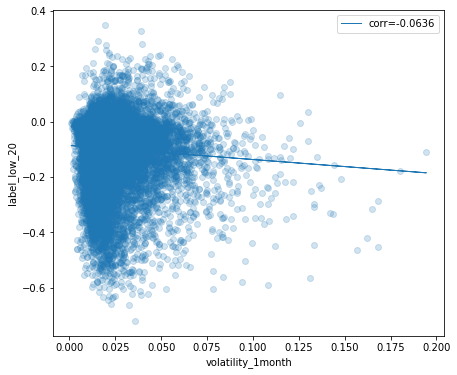

In [46]:
tmp = tmp_df.copy()
tmp["year"] = tmp["datetime"].dt.year
tmp["month"] = tmp["datetime"].dt.month
tmp["year_month"] = tmp["year"]*100 + tmp["month"]
tmp = tmp[tmp["year"]==2020]

fig,ax = plt.subplots(figsize=(7, 6))
ax.scatter(tmp["volatility_1month"], tmp["label_low_20"], alpha=0.2)
model=LinearRegression()
model.fit(tmp[["volatility_1month"]], tmp["label_low_20"])
ax.plot(tmp["volatility_1month"], model.predict(tmp[["volatility_1month"]]), lw=1.0)
ax.legend(["corr="+str(round(tmp["volatility_1month"].corr(tmp["label_low_20"]), 4))])
ax.set_xlabel("volatility_1month")
ax.set_ylabel("label_low_20")

さて、もう少し絞り込んでいきましょう。次は2020年前半（1月～6月）の散布図です（下図）。

Text(0, 0.5, 'label_low_20')

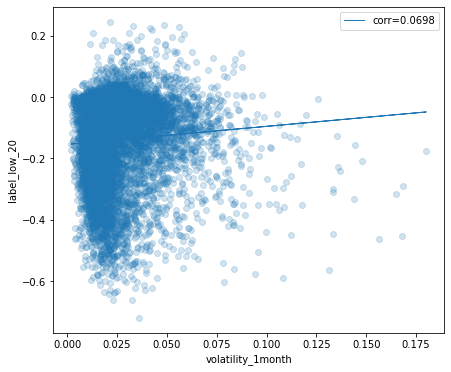

In [47]:
tmp = tmp_df.copy()
tmp["year"] = tmp["datetime"].dt.year
tmp["month"] = tmp["datetime"].dt.month
tmp["year_month"] = tmp["year"]*100 + tmp["month"]
tmp = tmp[(tmp["year"]==2020) & (tmp["month"]<=6)]

fig,ax = plt.subplots(figsize=(7, 6))
ax.scatter(tmp["volatility_1month"], tmp["label_low_20"], alpha=0.2)
model=LinearRegression()
model.fit(tmp[["volatility_1month"]], tmp["label_low_20"])
ax.plot(tmp["volatility_1month"], model.predict(tmp[["volatility_1month"]]), lw=1.0)
ax.legend(["corr="+str(round(tmp["volatility_1month"].corr(tmp["label_low_20"]), 4))])
ax.set_xlabel("volatility_1month")
ax.set_ylabel("label_low_20")

**ファッ！？？？？**

これはどういうことでしょう。**マイナスであるはずのvolatilityとlabel_low相関が、なんとプラスに逆転しています**。  
よく分からない現象が起きたため、さらに細かく各月の挙動を観察していきます。

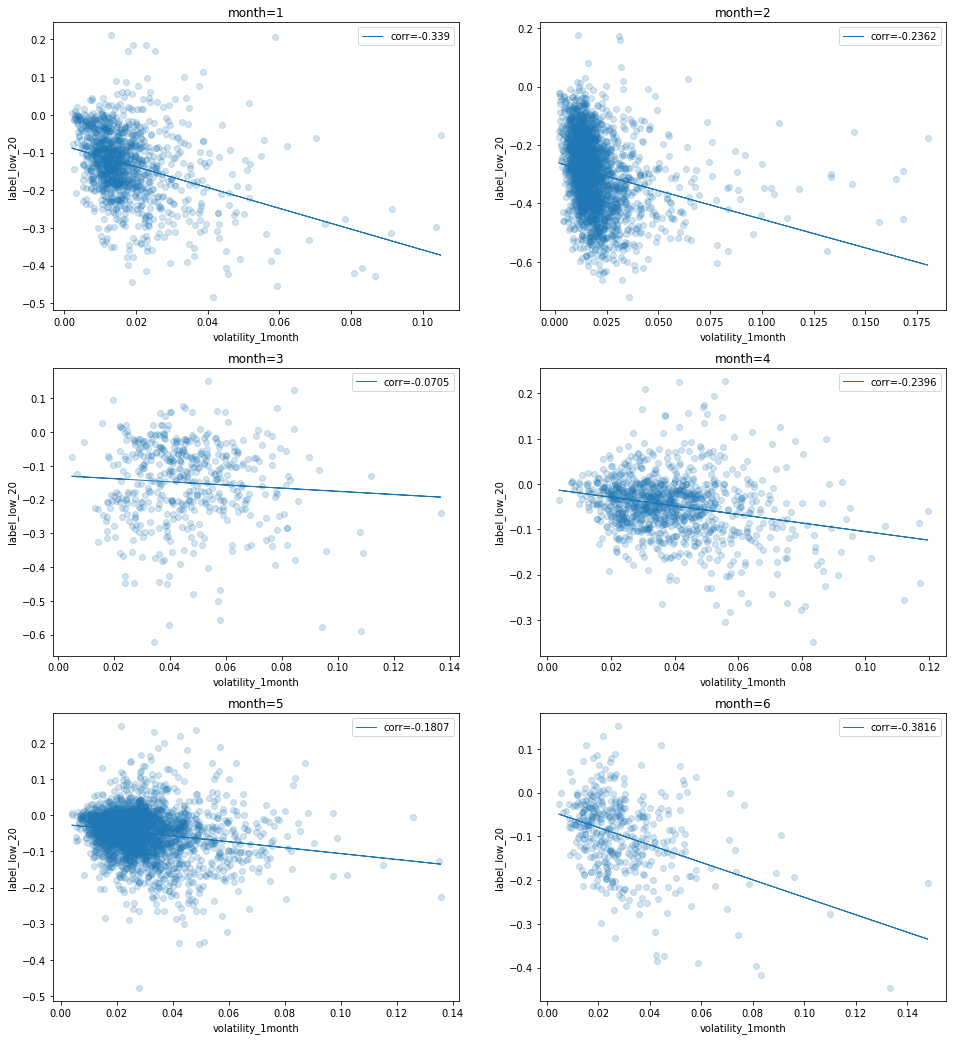

In [48]:
tmp = tmp_df.copy()
tmp["year"] = tmp["datetime"].dt.year
tmp["month"] = tmp["datetime"].dt.month
tmp["year_month"] = tmp["year"]*100 + tmp["month"]
tmp = tmp[tmp["year"]==2020]

fig,ax = plt.subplots(nrows=3, ncols=2, figsize=(16, 18))
for m in range(6):
    tmptmp = tmp[tmp["month"]==m+1]
    ax[int(m/2), m%2].scatter(tmptmp["volatility_1month"], tmptmp["label_low_20"], alpha=0.2)
    model=LinearRegression()
    model.fit(tmptmp[["volatility_1month"]], tmptmp["label_low_20"])
    ax[int(m/2), m%2].plot(tmptmp["volatility_1month"], model.predict(tmptmp[["volatility_1month"]]), lw=1.0)
    ax[int(m/2), m%2].legend(["corr="+str(round(tmptmp["volatility_1month"].corr(tmptmp["label_low_20"]), 4))])
    ax[int(m/2), m%2].set_title("month="+str(m+1))
    ax[int(m/2), m%2].set_xlabel("volatility_1month")
    ax[int(m/2), m%2].set_ylabel("label_low_20")

？？  
これはおかしいですね。全ての月でvolatility_1monthとlabel_lowの相関は想定通り負となってしまいました。

仕方がないので、1月から順番にデータを加えながらどこで挙動が変化するか確認していきます。

## 2020年1月のみ

Text(0, 0.5, 'label_low_20')

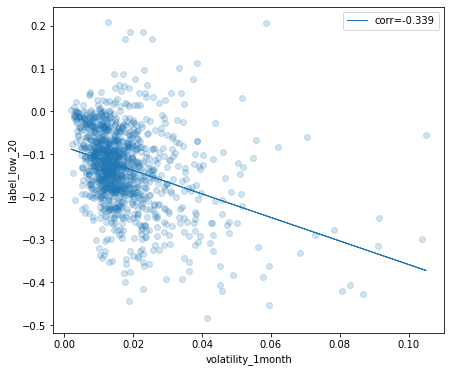

In [49]:
tmp = tmp_df.copy()
tmp["year"] = tmp["datetime"].dt.year
tmp["month"] = tmp["datetime"].dt.month
tmp["year_month"] = tmp["year"]*100 + tmp["month"]
tmp = tmp[(tmp["year"]==2020) & (tmp["month"]==1)]

fig,ax = plt.subplots(figsize=(7, 6))
ax.scatter(tmp["volatility_1month"], tmp["label_low_20"], alpha=0.2)
model=LinearRegression()
model.fit(tmp[["volatility_1month"]], tmp["label_low_20"])
ax.plot(tmp["volatility_1month"], model.predict(tmp[["volatility_1month"]]), lw=1.0)
ax.legend(["corr="+str(round(tmp["volatility_1month"].corr(tmp["label_low_20"]), 4))])
ax.set_xlabel("volatility_1month")
ax.set_ylabel("label_low_20")

## 2020年2月を追加

Text(0, 0.5, 'label_low_20')

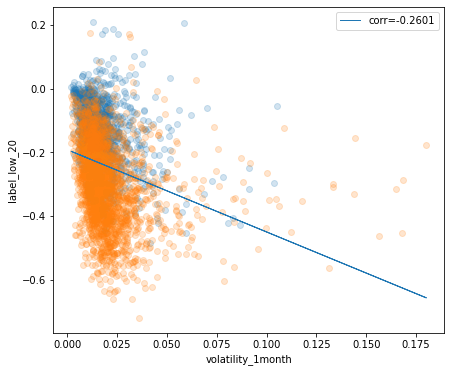

In [50]:
tmp = tmp_df.copy()
tmp["year"] = tmp["datetime"].dt.year
tmp["month"] = tmp["datetime"].dt.month
tmp["year_month"] = tmp["year"]*100 + tmp["month"]
tmp = tmp[(tmp["year"]==2020) & (tmp["month"]<=2)]

fig,ax = plt.subplots(figsize=(7, 6))
ax.scatter(tmp["volatility_1month"][tmp["month"]==1], tmp["label_low_20"][tmp["month"]==1], alpha=0.2)
ax.scatter(tmp["volatility_1month"][tmp["month"]==2], tmp["label_low_20"][tmp["month"]==2], alpha=0.2)
model=LinearRegression()
model.fit(tmp[["volatility_1month"]], tmp["label_low_20"])
ax.plot(tmp["volatility_1month"], model.predict(tmp[["volatility_1month"]]), lw=1.0)
ax.legend(["corr="+str(round(tmp["volatility_1month"].corr(tmp["label_low_20"]), 4))])
ax.set_xlabel("volatility_1month")
ax.set_ylabel("label_low_20")

## 2020年3月を追加

Text(0, 0.5, 'label_low_20')

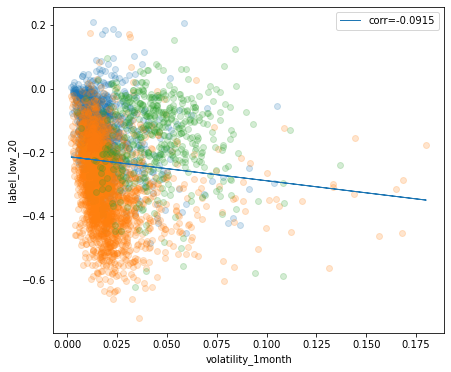

In [51]:
tmp = tmp_df.copy()
tmp["year"] = tmp["datetime"].dt.year
tmp["month"] = tmp["datetime"].dt.month
tmp["year_month"] = tmp["year"]*100 + tmp["month"]
tmp = tmp[(tmp["year"]==2020) & (tmp["month"]<=3)]

fig,ax = plt.subplots(figsize=(7, 6))
ax.scatter(tmp["volatility_1month"][tmp["month"]==1], tmp["label_low_20"][tmp["month"]==1], alpha=0.2)
ax.scatter(tmp["volatility_1month"][tmp["month"]==2], tmp["label_low_20"][tmp["month"]==2], alpha=0.2)
ax.scatter(tmp["volatility_1month"][tmp["month"]==3], tmp["label_low_20"][tmp["month"]==3], alpha=0.2)
model=LinearRegression()
model.fit(tmp[["volatility_1month"]], tmp["label_low_20"])
ax.plot(tmp["volatility_1month"], model.predict(tmp[["volatility_1month"]]), lw=1.0)
ax.legend(["corr="+str(round(tmp["volatility_1month"].corr(tmp["label_low_20"]), 4))])
ax.set_xlabel("volatility_1month")
ax.set_ylabel("label_low_20")

ここで少し相関が低くなりましたが、まだまだ負のままです。
## 2020年4月を追加

Text(0, 0.5, 'label_low_20')

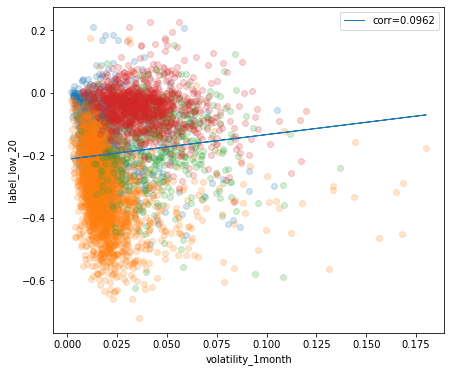

In [52]:
tmp = tmp_df.copy()
tmp["year"] = tmp["datetime"].dt.year
tmp["month"] = tmp["datetime"].dt.month
tmp["year_month"] = tmp["year"]*100 + tmp["month"]
tmp = tmp[(tmp["year"]==2020) & (tmp["month"]<=4)]

fig,ax = plt.subplots(figsize=(7, 6))
ax.scatter(tmp["volatility_1month"][tmp["month"]==1], tmp["label_low_20"][tmp["month"]==1], alpha=0.2)
ax.scatter(tmp["volatility_1month"][tmp["month"]==2], tmp["label_low_20"][tmp["month"]==2], alpha=0.2)
ax.scatter(tmp["volatility_1month"][tmp["month"]==3], tmp["label_low_20"][tmp["month"]==3], alpha=0.2)
ax.scatter(tmp["volatility_1month"][tmp["month"]==4], tmp["label_low_20"][tmp["month"]==4], alpha=0.2)
model=LinearRegression()
model.fit(tmp[["volatility_1month"]], tmp["label_low_20"])
ax.plot(tmp["volatility_1month"], model.predict(tmp[["volatility_1month"]]), lw=1.0)
ax.legend(["corr="+str(round(tmp["volatility_1month"].corr(tmp["label_low_20"]), 4))])
ax.set_xlabel("volatility_1month")
ax.set_ylabel("label_low_20")

ここで完全におかしくなってしまったことが分かります。これらの現象をまとめると、

- 月単位のような限定した期間で観察すると、ボラティリティとラベルLowは確かに負相関である。  
（2020年3月は説明力が低いが、それでも負相関である）
- 2020年4月はコロナショックから大きなリバウンドがあり、ラベルLowの分布が著しくプラスにシフトした。
- この2020年4月のデータが他と混ざると、局所的には正しい特性が全体で見たときに消失する現象が起きている。

これがLB期間でLow側の予測力が劣化する要因です。

ここで大事なことは、**実際の評価期間は2021年3月末～5月中旬の1ヶ月半であるので、1年間という長期間のリーダーボード条件でスコアを向上させることが必ずしも良い結果に繋がるとは限らない**ということです。

コメントがございましたらどうぞお願い致します。
以上。